# Lending Club Loan Default Predictions 1
**Author: Thomas Loeber**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Predictive-modeling" data-toc-modified-id="Predictive-modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Predictive modeling</a></span></li><li><span><a href="#Load-pickled-data" data-toc-modified-id="Load-pickled-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load pickled data</a></span></li></ul></div>

In [5]:
import pdb 
import glob
import copy
import math
import pickle

import numpy as np
import pandas as pd
import scipy as sp
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import missingno  # for visualizing missing data

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

In [6]:
# Load data
with open('data_processed/all_data.pickle', 'rb') as pickled_file: 
    all_data = pickle.load(pickled_file) # Un-pickle file

## Preprocessing

In [7]:
# Inspect number of categories for categorical variables
all_data.select_dtypes(include='object') \
    .nunique() \
    .sort_values(ascending=False) \
    .head()

emp_title     322952
title          62405
zip_code         938
addr_state        51
purpose           14
dtype: int64

In [8]:
# Drop categorical variables with too many categories (over 900)
all_data = all_data.drop(['emp_title','title', 'zip_code'], 
                         axis='columns')

In [10]:
## Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(all_data.drop('default', axis='columns'),
                     all_data.default,
                     test_size=0.2, random_state=1,
                     shuffle=True, stratify=all_data.default) 

In [9]:
# Imputation and standardization for numeric features
numeric_features = X_train.select_dtypes(include=[np.number]).columns
numeric_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Imputation and one-hot encoding for categorical features
categorical_features = X_train.select_dtypes(include=[object]).columns
categorical_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())])

# Combining preprocessing for both kinds of features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('', categorical_transformer, categorical_features)],
    remainder='passthrough', n_jobs=1)

# Apply preprocessing
X_train_p = preprocessor.fit_transform(X_train)

# # Make combined pipeline and fit model
# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', LogisticRegression(
#                           C=0.01, random_state=0, 
#                           solver='saga'))])

# clf.fit(X_train, y_train)

In [14]:
# Pickle X_train_p
with open('data_processed/X_train_p.pickle', 'wb') as pickled_file: 
    pickle.dump(X_train_p, pickled_file) 

In [11]:
X_train_p.shape

(818660, 169)

## PCA

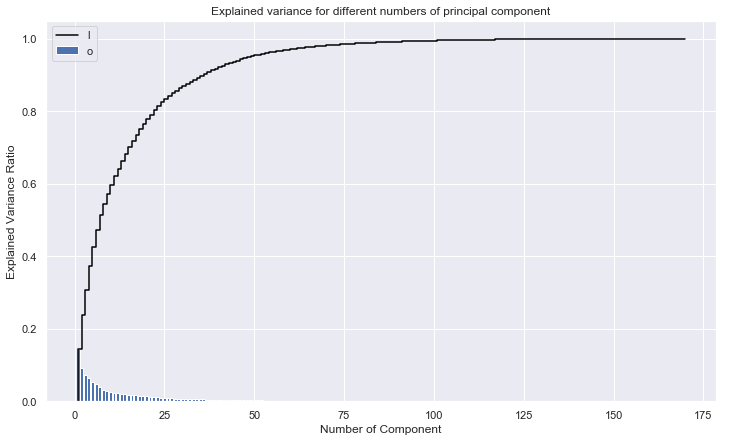

In [13]:
# Use PCA to assess whether features lie in lower-
# dimensional subspace
pca = PCA()
pca.fit(X_train_p)
explained_var = pca.explained_variance_ratio_

# Plot results
plt.figure(figsize=(12, 7))
plt.step(range(1, len(explained_var)+2),
         np.hstack([[0], np.cumsum(explained_var)]),
         color='black', label='Cumulative')
plt.bar(range(1, len(explained_var)+1),
        explained_var, 
        label='per principal component')
plt.legend('lowerright')
plt.title('Explained variance for different numbers of principal component')
plt.ylim(0,1.05)
plt.xlabel('Number of Component')
plt.ylabel('Explained Variance Ratio')
plt.show();

In [11]:
# Ridge
lr_cv = LogisticRegressionCV(Cs = 4, solver='saga', cv=3,
    random_state=1, penalty='l2', class_weight='balanced')
lr_cv.fit(X_train_p, y_train) 

C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

LogisticRegressionCV(Cs=4, class_weight='balanced', cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
           refit=True, scoring=None, solver='saga', tol=0.0001, verbose=0)

In [14]:
# Lasso
lr_cv = LogisticRegressionCV(Cs = 4, solver='saga', cv=3,
    random_state=1, penalty='l1', class_weight='balanced')
lr_cv.fit(X_train_p, y_train) 

C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

LogisticRegressionCV(Cs=4, class_weight='balanced', cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
           refit=True, scoring=None, solver='saga', tol=0.0001, verbose=0)

## Predictive modeling
We will model loan default as dichotomous, either yes or no. While it is generally best to model the phenomenon of interest at the most fine-ingrained measurement scale possible in order to minimize a model's variance, we unfortunately do not have all the required information to model default as the return on investment. Doing so would be advantageous, because it would take into account that earlier default is worse than later default. Thus, if the different features vary in terms of *when* the default that they can predict is most likely to occur, modeling the ROI would allow us to make more accurate decisions whether a specific customer is profitable.

Unfortunately, though, we don't have all the information to calculate the *time* value of payments received: Even though we do have the total amount of payments from each borrower, we don't know at what times these were received.  (Though we could try to impute these based on a number of pieces of information we do have available, the additional error introduced by this imputation is likely to outweigh any gains made from modeling default as a continuous event.) Therefore, I will model default as a dichotomous variable.

## Load pickled data

In [84]:
# Raise error, because we only want to execute the next cells manually
raise Exception

Exception: 

In [4]:
# Un-pickle files
# X_train_p
import pickle
with open('data_processed/X_train_preprocessed.pickle', 'rb') as pickled_file: 
    X_train_p = pickle.load(pickled_file) 